In [ ]:
!pip3 install scikit-learn
!pip3 install --upgrade ../.
!apt-get update
!apt-get install ffmpeg x264 libx264-dev libsm6 libxext6  -y
!pip install --upgrade opencv-python

In [40]:
from IPython.utils import io
import os
import subprocess
from tqdm.notebook import tqdm

import jax
import jax.numpy as jnp
import jax.lax as lax
from jax import jit, grad, vmap, jacfwd, jacrev, hessian
import haiku as hk

import sys
sys.path.append('/opt/conda/lib/python3.7/site-packages')

import os
os.environ['TF_FORCE_UNIFIED_MEMORY'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '2.0'

from urllib import request
from concurrent import futures
import json
from matplotlib import gridspec
from matplotlib.colors import hsv_to_rgb
import matplotlib.pyplot as plt
import numpy as np
#import py3Dmol

from functools import partial
import math
import sklearn
from sklearn.decomposition import PCA
import scipy

import alphafold

from alphafold.data import parsers
from alphafold.data import pipeline
from alphafold.data.tools import jackhmmer

from alphafold.common import protein

from alphafold.relax import relax
from alphafold.relax import utils

from IPython import display
from ipywidgets import GridspecLayout
from ipywidgets import Output

from enum import Enum

from numpy.polynomial import polynomial as P

import cv2
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import zscore

In [9]:
## alphafold-inspect

class MODEL_NAMES(Enum):
    model_1 = 'model_1'
    model_2 = 'model_2'
    model_3 = 'model_3'
    model_4 = 'model_4'
    model_5 = 'model_5'
    model_1_ptm = 'model_1_ptm'
    model_2_ptm = 'model_2_ptm'
    model_3_ptm = 'model_3_ptm'
    model_4_ptm = 'model_4_ptm'
    model_5_ptm = 'model_5_ptm'
    
    
def load_model(folder, model_name):
    model_name = MODEL_NAMES[model_name].value
    from alphafold.model import config
    from alphafold.model import data
    config = config.model_config(model_name)
    params = data.get_model_haiku_params(model_name, folder)
    return config, params


class _LayerWrapper:
    layer_name = "layer/"
    param_basename = 'alphafold/'
    param_keys = []
    pca_param_key = 0
    base_model = None
    
    def __init__(self, config, params=None, batch_shape=(1,), rng_key=0):
        self.config = config
        self.batch_shape = tuple(batch_shape)
        self.rng_key = jax.random.PRNGKey(rng_key)
        
        self.param_basename += self.layer_name
        self.param_names = [self.param_basename + k for k in self.param_keys]
        self.layer_param_names = [self.layer_name + k for k in self.param_keys]
        
        self.params = self.init_params()
        if params is not None:
            self.load_params(params)
            
        if self.pca_param_key >= 0:
            self.pca = PCA().fit(self.params[self.layer_param_names[self.pca_param_key]]["weights"].T)
            self.components = jax.device_put(self.pca.components_)
        
    @property
    def from_pca(self):
        @jax.jit
        def _from_pca(x):
            n_components = x.shape[-1]
            return jnp.matmul(x, self.components[:n_components])
        return _from_pca
    
    @property
    def to_pca(self, n_components=3):
        @jax.jit
        def _to_pca(x):
            return jnp.matmul(x, self.components[:n_components].T)
        return _to_pca
      
    @property
    def random_key(self):
        return jax.random.split(self.rng_key)[1]
        
    @property
    def init_shape(self):
        return (0,)
        
    def init_params(self):
        init_tensor = jnp.zeros(self.init_shape)
        layer_params = hk.data_structures.to_mutable_dict(self.forward_init(self.random_key, init_tensor))
        return layer_params
    
    def load_params(self, params):
        for b, p in zip(self.layer_param_names, self.param_names):
            pdict = {}
            for k, v in params[p].items():
                if getattr(self, 'layer_id', False):
                    v = v[self.layer_id]
                pdict[k] = v
            self.params[b] = pdict
    
    @property
    def local_config(self):
        return self.config
    
    @property
    def global_config(self):
        return self.config.model.global_config
    
    @property
    def model(self):
        name = self.layer_name.replace('/', '')
        return self.base_model(self.local_config, self.global_config, name=name)

    @property
    def _forward(self):
        def _forward(x):
            return self.model(x)
        return _forward
    
    @property
    def forward_init(self):
        return hk.transform(self._forward).init
    
    @property
    def forward_apply(self):
        apply = hk.transform(self._forward).apply
        return partial(apply, self.params, self.random_key)
    
    @property
    def forward_residual(self):
        @jax.jit
        def _forward_residual(x):
            return x + self.forward_apply(x)
        return _forward_residual
    
    @property
    def jacobian(self):
        return jax.jacfwd(self.forward_apply)
    
    @property
    def hessian(self):
        return jax.jacfwd(jax.jacrev(self.forward_apply))
    
class Linear(hk.Module):
    def __init__(self,
               num_output: int,
               initializer: str = 'linear',
               use_bias: bool = True,
               bias_init: float = 0.,
               name: str = 'linear'):
        super().__init__(name=name)
        self.num_output = num_output
        self.initializer = initializer
        self.use_bias = use_bias
        self.bias_init = bias_init

    def __call__(self, inputs: jnp.ndarray) -> jnp.ndarray:
        n_channels = int(inputs.shape[-1])

        weight_shape = [n_channels, self.num_output]
        if self.initializer == 'linear':
            weight_init = hk.initializers.VarianceScaling(mode='fan_in', scale=1.)
        elif self.initializer == 'relu':
            weight_init = hk.initializers.VarianceScaling(mode='fan_in', scale=2.)
        elif self.initializer == 'zeros':
            weight_init = hk.initializers.Constant(0.0)

        weights = hk.get_parameter('weights', weight_shape, inputs.dtype,
                                   weight_init)

        output = jnp.einsum('...c,cd->...d', inputs, weights)
        # this is equivalent to einsum('...c,cd->...d', inputs, weights)
        # but turns out to be slightly faster
        #inputs = jnp.swapaxes(inputs, -1, -2)
        #output = jnp.einsum('...cb,cd->...db', inputs, weights)
        #output = jnp.swapaxes(output, -1, -2)

        if self.use_bias:
            bias = hk.get_parameter('bias', [self.num_output], inputs.dtype,
                                  hk.initializers.Constant(self.bias_init))
            output += bias

        return output
    
class TransitionRunner(hk.Module):
    def __init__(self, config, global_config, name='transition_block'):
        super().__init__(name=name)
        self.config = config
        self.global_config = global_config

    def __call__(self, act):
        nc = act.shape[-1]
        num_intermediate = int(nc * self.config.num_intermediate_factor)

        return hk.Sequential([
            hk.LayerNorm(
                axis=[-1],
                create_scale=True,
                create_offset=True,
                name='input_layer_norm'),
            Linear(
                num_intermediate,
                initializer='relu',
                name='transition1'),
            jax.nn.relu,
            Linear(
                nc,
                initializer=alphafold.model.utils.final_init(self.global_config),
                name='transition2')
        ])(act)
    
class PairTransition(_LayerWrapper):
    layer_name = "pair_transition/"
    param_basename = "alphafold/alphafold_iteration/evoformer/evoformer_iteration/"
    param_keys = ['input_layer_norm', 'transition1', 'transition2']
    pca_param_key = 1
    base_model = TransitionRunner
    
    def __init__(self, layer_id, *args, **kwargs):
        self.layer_id = layer_id
        super(PairTransition, self).__init__(*args, **kwargs)
        
    @property
    def init_shape(self):
        c = self.config.model.embeddings_and_evoformer.pair_channel
        return (c,)
        
    @property
    def local_config(self):
        return self.config.model.embeddings_and_evoformer.evoformer.pair_transition

class TransitionRunner_NoLN(hk.Module):
    def __init__(self, config, global_config, name='transition_block'):
        super().__init__(name=name)
        self.config = config
        self.global_config = global_config

    def __call__(self, act):
        nc = act.shape[-1]
        num_intermediate = int(nc * self.config.num_intermediate_factor)

        return hk.Sequential([
            Linear(
                num_intermediate,
                initializer='relu',
                name='transition1'),
            jax.nn.relu,
            Linear(
                nc,
                initializer=alphafold.model.utils.final_init(self.global_config),
                name='transition2')
        ])(act)
    
class PairTransition_NoLN(_LayerWrapper):
    layer_name = "pair_transition/"
    param_basename = "alphafold/alphafold_iteration/evoformer/evoformer_iteration/"
    param_keys = ['transition1', 'transition2']
    pca_param_key = 0
    base_model = TransitionRunner_NoLN
    
    def __init__(self, layer_id, *args, **kwargs):
        self.layer_id = layer_id
        super(PairTransition_NoLN, self).__init__(*args, **kwargs)
        
    @property
    def init_shape(self):
        c = self.config.model.embeddings_and_evoformer.pair_channel
        return (c,)
        
    @property
    def local_config(self):
        return self.config.model.embeddings_and_evoformer.evoformer.pair_transition
    
class TransitionRunner_OnlyLN(hk.Module):
    def __init__(self, config, global_config, name='transition_block'):
        super().__init__(name=name)
        self.config = config
        self.global_config = global_config

    def __call__(self, act):
        nc = act.shape[-1]
        num_intermediate = int(nc * self.config.num_intermediate_factor)

        return hk.Sequential([
            hk.LayerNorm(
                axis=[-1],
                create_scale=True,
                create_offset=True,
                name='input_layer_norm')
        ])(act)
    
class PairTransition_OnlyLN(_LayerWrapper):
    layer_name = "pair_transition/"
    param_basename = "alphafold/alphafold_iteration/evoformer/evoformer_iteration/"
    param_keys = ['input_layer_norm']
    pca_param_key = -1
    base_model = TransitionRunner_OnlyLN
    
    def __init__(self, layer_id, *args, **kwargs):
        self.layer_id = layer_id
        super(PairTransition_OnlyLN, self).__init__(*args, **kwargs)
        
    @property
    def init_shape(self):
        c = self.config.model.embeddings_and_evoformer.pair_channel
        return (c,)
        
    @property
    def local_config(self):
        return self.config.model.embeddings_and_evoformer.evoformer.pair_transition
    

    
def from_spherical(angle_grid, r):
    return np.stack([
        r * np.cos(angle_grid[...,0]) * np.sin(angle_grid[...,1]),
        r * np.sin(angle_grid[...,0]) * np.sin(angle_grid[...,1]),
        r * np.cos(angle_grid[..., 1])
    ], axis=-1)

def to_spherical(xyz):
    return np.stack([
        np.atan2(xyz[...,1], xyz[...,0]),
        np.atan2(np.linalg.norm(xyz[...,:2], axis=-1), xyz[...,2]),
        np.linalg.norm(xyz, axis=-1)
    ], axis=-1)

def get_grid_ns(n: int = 300, dims: int = 2, sizes = (-1.0, 1.0)):
    if type(n) is int:
        n = [n] * dims
    if type(sizes[0]) in [float, int]:
        sizes = [sizes] * dims

    steps = [np.linspace(sizes[i][0], sizes[i][1], n[i]) for i in range(dims)]
    return np.stack(np.meshgrid(*steps), axis=-1)

In [10]:
layer_idx = 34

params_folder = '../alphafold/data'
model_name = 'model_2'

config, params = load_model(params_folder, model_name)
layer = PairTransition(layer_idx, config, params)
layer_noln = PairTransition_NoLN(layer_idx, config, params)
layer_onlyln = PairTransition_OnlyLN(layer_idx, config, params)

In [11]:
def pre_fn(x):
    proj = layer_noln.from_pca(x)
    proj = layer_onlyln.forward_apply(proj)
    return proj
vj_pre_fn = vmap(jit(pre_fn))

vj_forward = vmap(jit(layer.forward_residual))

def newton(x):
    y = layer_noln.forward_apply(x)
    j = layer_noln.jacobian(x)
    delta_x = jnp.linalg.solve(j, y) #because pseudo-inverse is unstable
    return x - 0.1 * delta_x
vj_newton = vmap(jit(newton))

#def newton(x):
#    g = layer.jacobian(x)
#    gg = layer.hessian(x)
#    
#    print(g.shape, gg.shape, jnp.abs(g).mean(), g.max(), jnp.abs(gg).mean(), gg.max())
#    
#    return x - (g / gg)
#vj_newton = newton

In [239]:
batch_size = 10
pre_iter_steps = 1
iteration_steps = 1000

point = jax.random.normal(
    layer_noln.rng_key,
    (batch_size, layer_noln.init_shape[-1])
)

points = jnp.zeros((batch_size, iteration_steps, layer_noln.init_shape[-1]))
points = jax.ops.index_update(
    points,
    jax.ops.index[:,0,:],
    vj_pre_fn(point)
)

#iterate normally first, then search for fixed points
for i in tqdm(range(pre_iter_steps), "forward"):
    points = jax.ops.index_update(
        points,
        jax.ops.index[:,0,:],
        vj_forward(points[:,0,:])
    )

for i in tqdm(range(iteration_steps - 1), "newton"):
    point = vj_newton(points[:,i,:])
    points = jax.ops.index_update(
        points,
        jax.ops.index[:,i + 1,:],
        point
    )

forward:   0%|          | 0/1 [00:00<?, ?it/s]

newton:   0%|          | 0/999 [00:00<?, ?it/s]

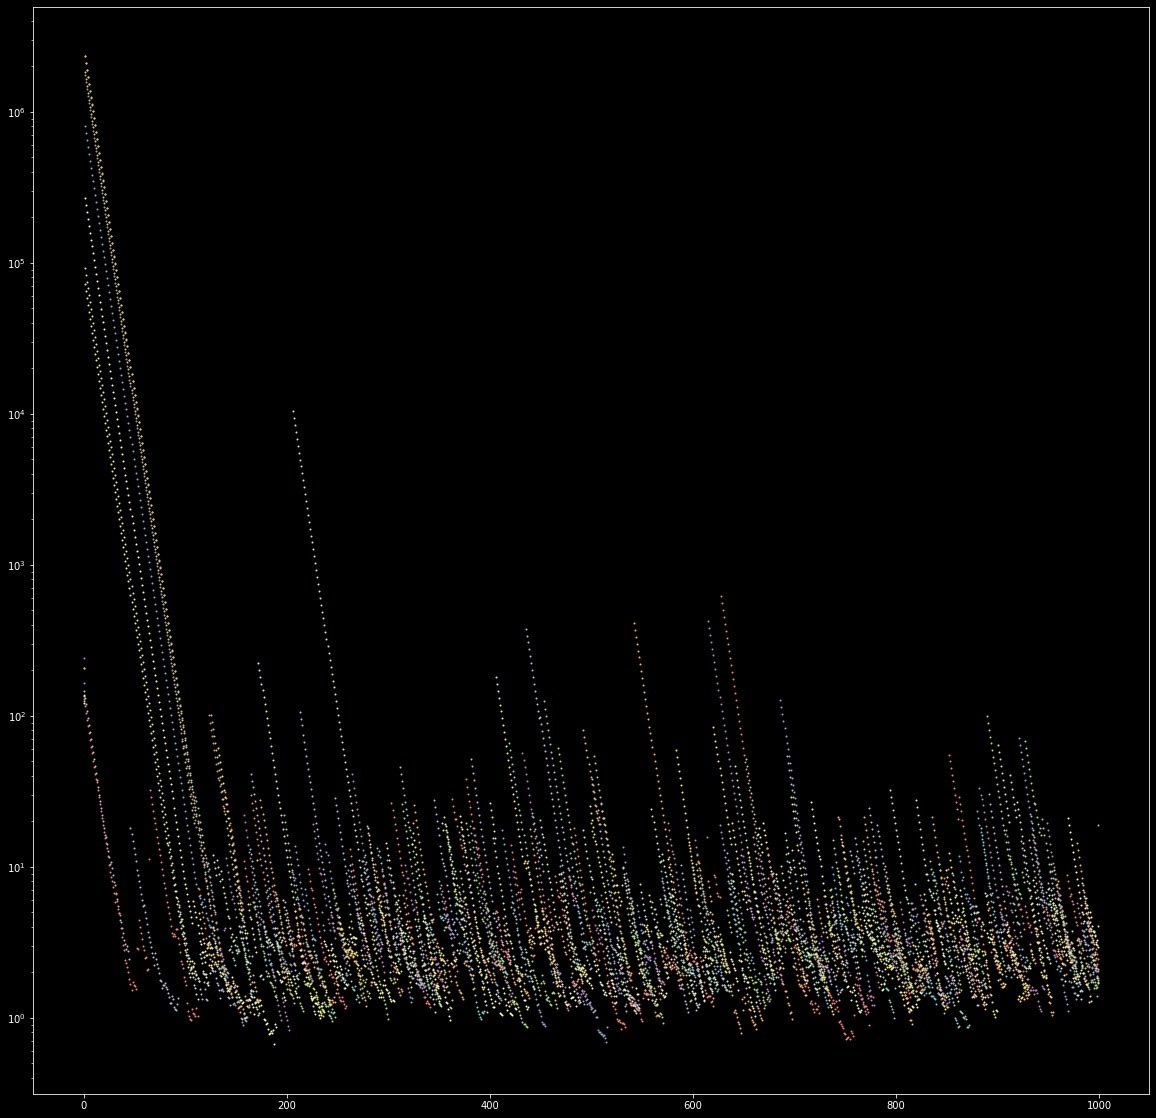

In [240]:
for i in range(points.shape[0]):
    plt.scatter(
        jnp.arange(points.shape[1]), 
        jnp.linalg.norm(points[i], axis=-1),
        s=1
    )
plt.yscale('log')
plt.gcf().set_size_inches(20, 20)
plt.show()

# Newton on 2-Norm

In [23]:
def pre_fn(x):
    proj = layer_noln.from_pca(x)
    proj = layer_onlyln.forward_apply(proj)
    return proj
vj_pre_fn = vmap(jit(pre_fn))

def out_proj(x):
    return layer_noln.to_pca(x)
vj_out_proj = vmap(jit(out_proj))

vj_forward = vmap(jit(layer.forward_residual))

def forward_norm(x):
    out = layer_noln.forward_apply(x)
    return jnp.linalg.norm(out)

step_size = 1

def newton(x):
    return x - step_size * grad(forward_norm)(x)
vj_newton = vmap(jit(newton))

def jac_det_tr(x):
    J = layer_noln.jacobian(x)
    sign, logdet = jnp.linalg.slogdet(J)
    trace = jnp.trace(J, axis1=-2, axis2=-1)
    return sign, logdet, trace, J.min(), J.max()
vj_jac_det_tr = vmap(jit(jac_det_tr))

In [70]:
norm = lambda x: jnp.linalg.norm(x, axis=-1)

def find_fp_1var(
    point,
    var_fn=norm,
    pre_iter_steps=1, 
    iteration_steps=50,
    pbar=False
    ):

    points = jnp.zeros((point.shape[0], 2, layer_noln.init_shape[-1]))
    points = jax.ops.index_update(
        points,
        jax.ops.index[:,0,:],
        vj_pre_fn(point)
    )

    #iterate normally first, then search for fixed points
    for i in tqdm(range(pre_iter_steps), "forward", disable=not pbar):
        points = jax.ops.index_update(
            points,
            jax.ops.index[:,0,:],
            vj_forward(points[:,0,:])
        )

    bool_flag = 0
    for i in tqdm(range(iteration_steps - 1), "newton", disable=not pbar):
        next_flag = (bool_flag + 1) % 2
        point = vj_newton(points[:,bool_flag,:])
        points = jax.ops.index_update(
            points,
            jax.ops.index[:,next_flag,:],
            point
        )
        bool_flag = next_flag

    next_flag = (bool_flag + 1) % 2
    converged = jnp.isclose(var_fn(points[:,next_flag] - points[:,bool_flag]), 0)
    points = points[converged,bool_flag]
    return points

def from_spherical(angle_grid, r):
    return jnp.stack([
        r * jnp.cos(angle_grid[...,0]) * jnp.sin(angle_grid[...,1]),
        r * jnp.sin(angle_grid[...,0]) * jnp.sin(angle_grid[...,1]),
        r * jnp.cos(angle_grid[..., 1])
    ], axis=-1)

def to_spherical(xyz):
    return jnp.stack([
        jnp.arctan2(xyz[...,1], xyz[...,0]),
        jnp.arctan2(jnp.linalg.norm(xyz[...,:2], axis=-1), xyz[...,2]),
        jnp.linalg.norm(xyz, axis=-1)
    ], axis=-1)

def get_grid_ns(n: int = 300, dims: int = 2, sizes = (-1.0, 1.0)):
    if type(n) is int:
        n = [n] * dims
    if type(sizes[0]) in [float, int]:
        sizes = [sizes] * dims

    steps = [jnp.linspace(sizes[i][0], sizes[i][1], n[i]) for i in range(dims)]
    return jnp.stack(jnp.meshgrid(*steps), axis=-1)

def random_points(rng_key, n: int = 1000, shape: int = 128):
    return jax.random.normal(rng_key, (n, shape))


vj_in_proj = vmap(layer_noln.from_pca)

  0%|          | 0/11 [00:00<?, ?it/s]

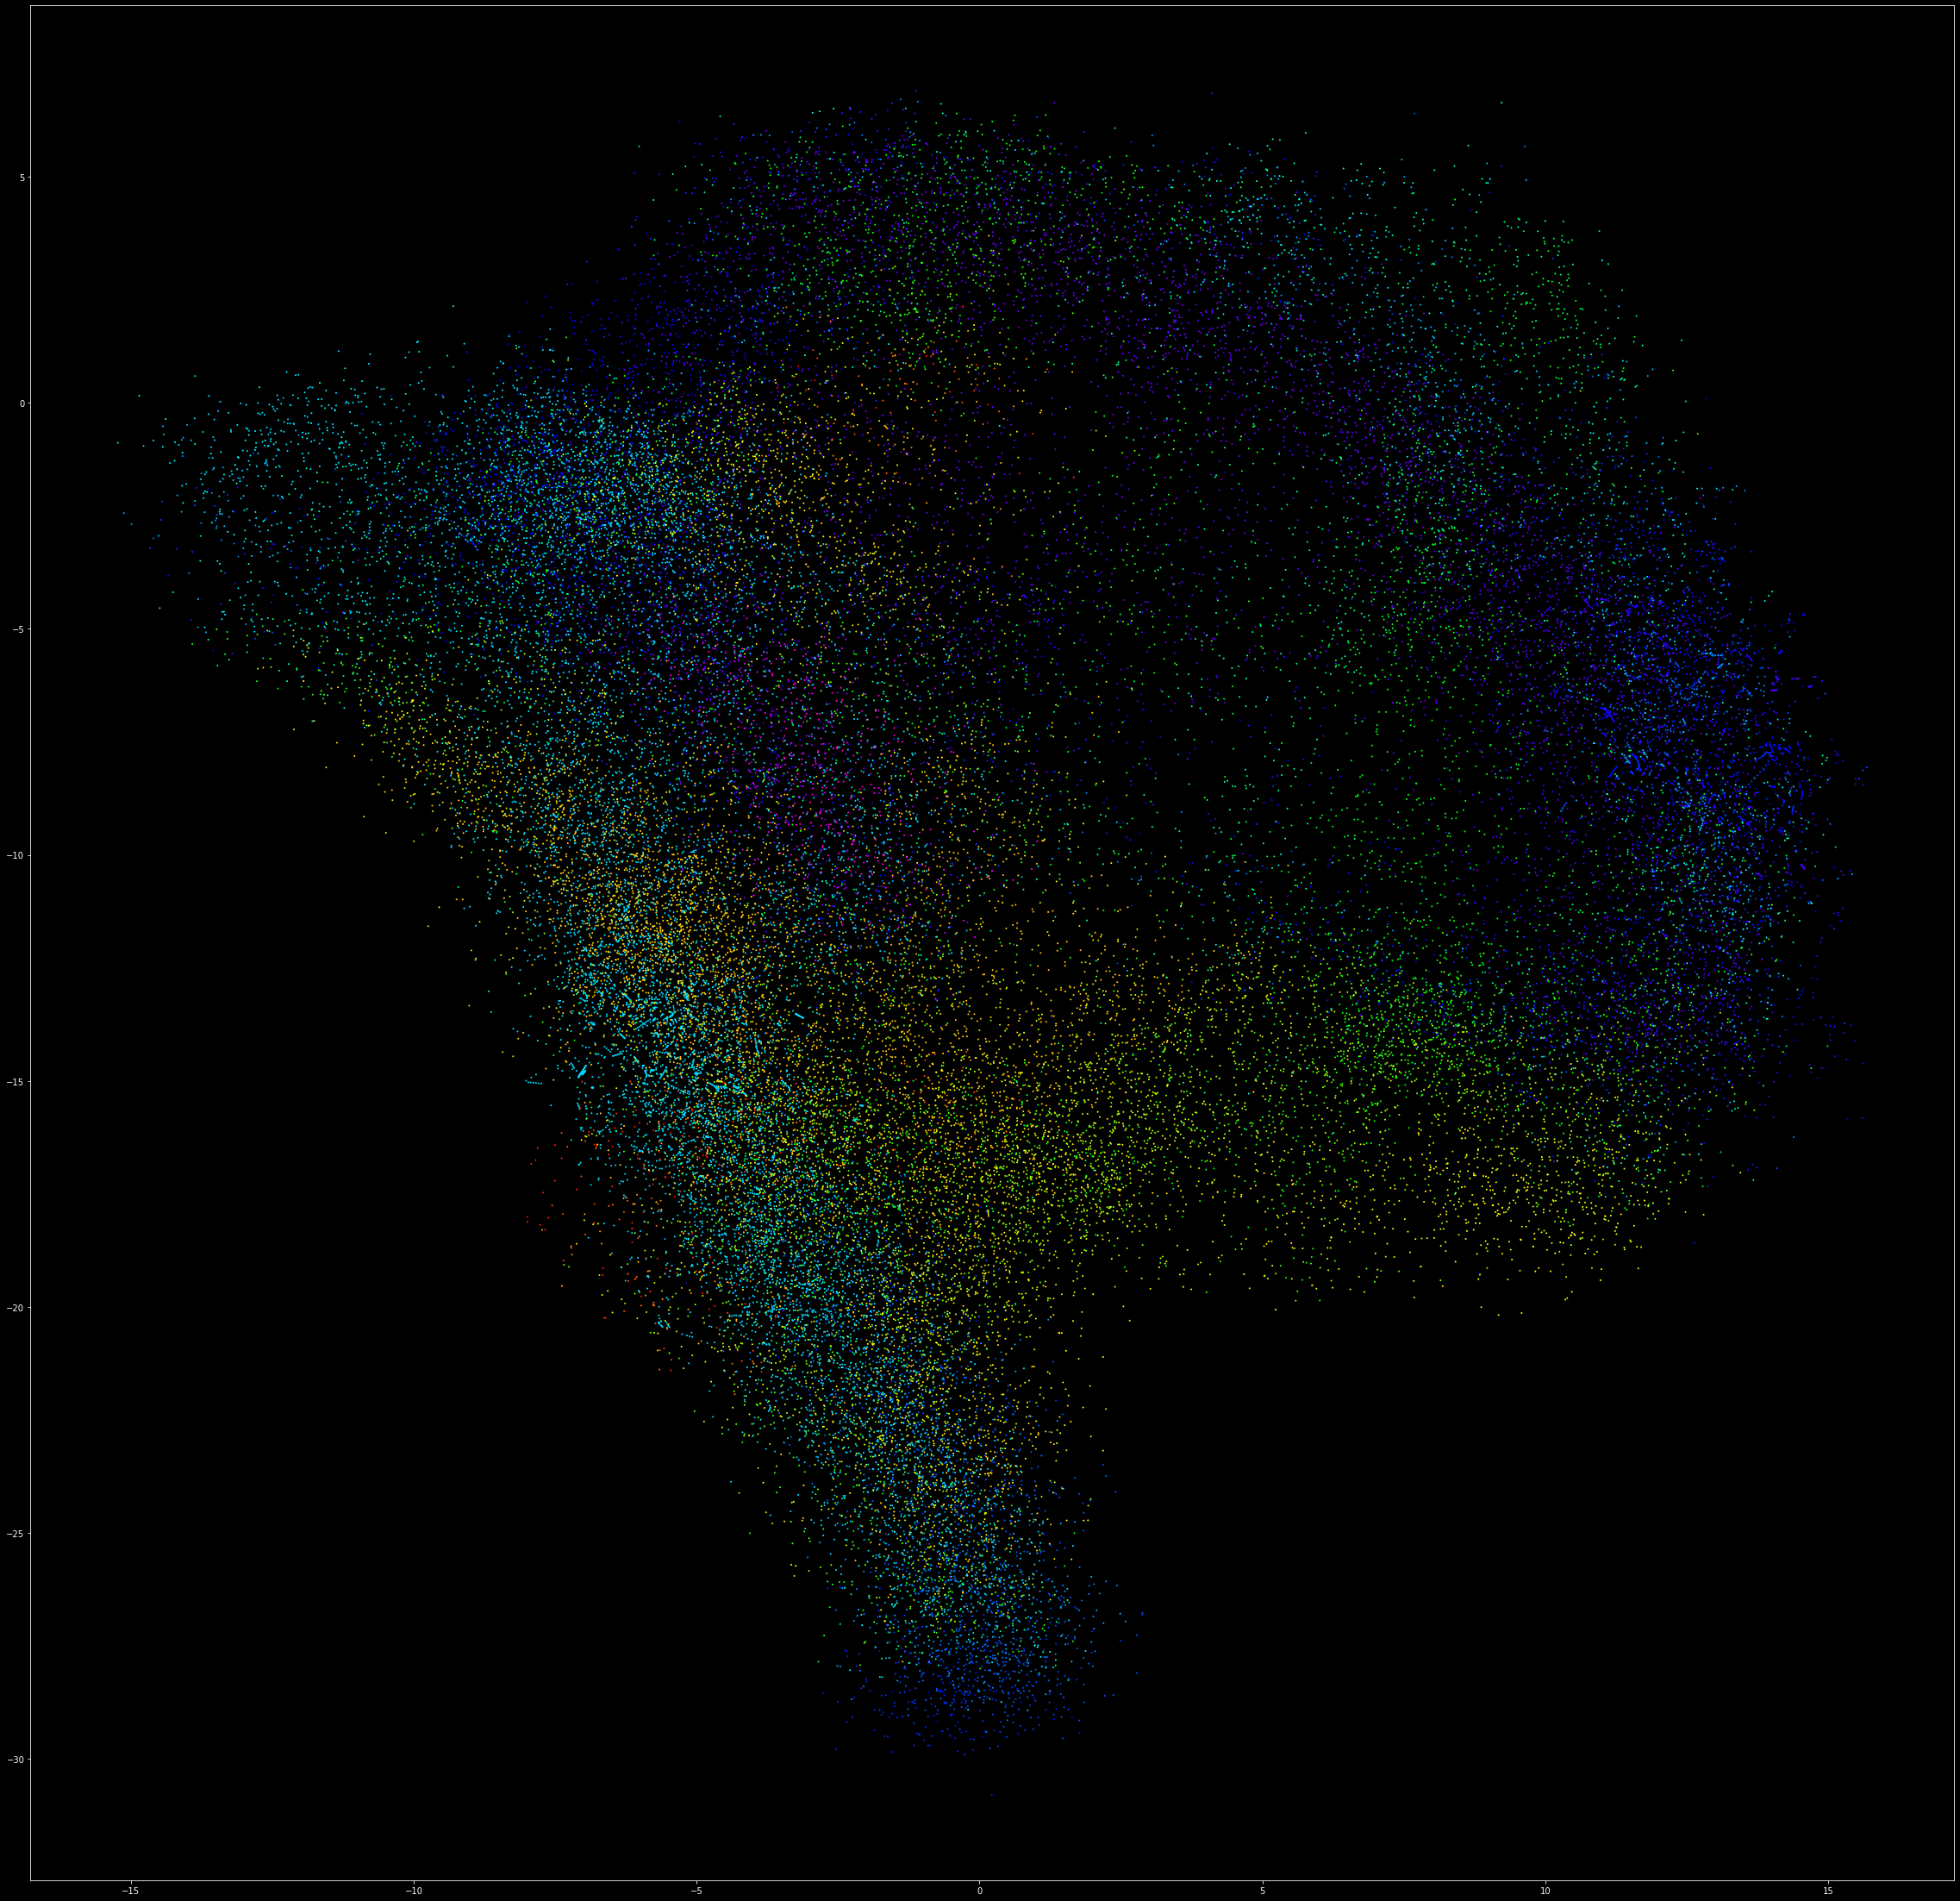

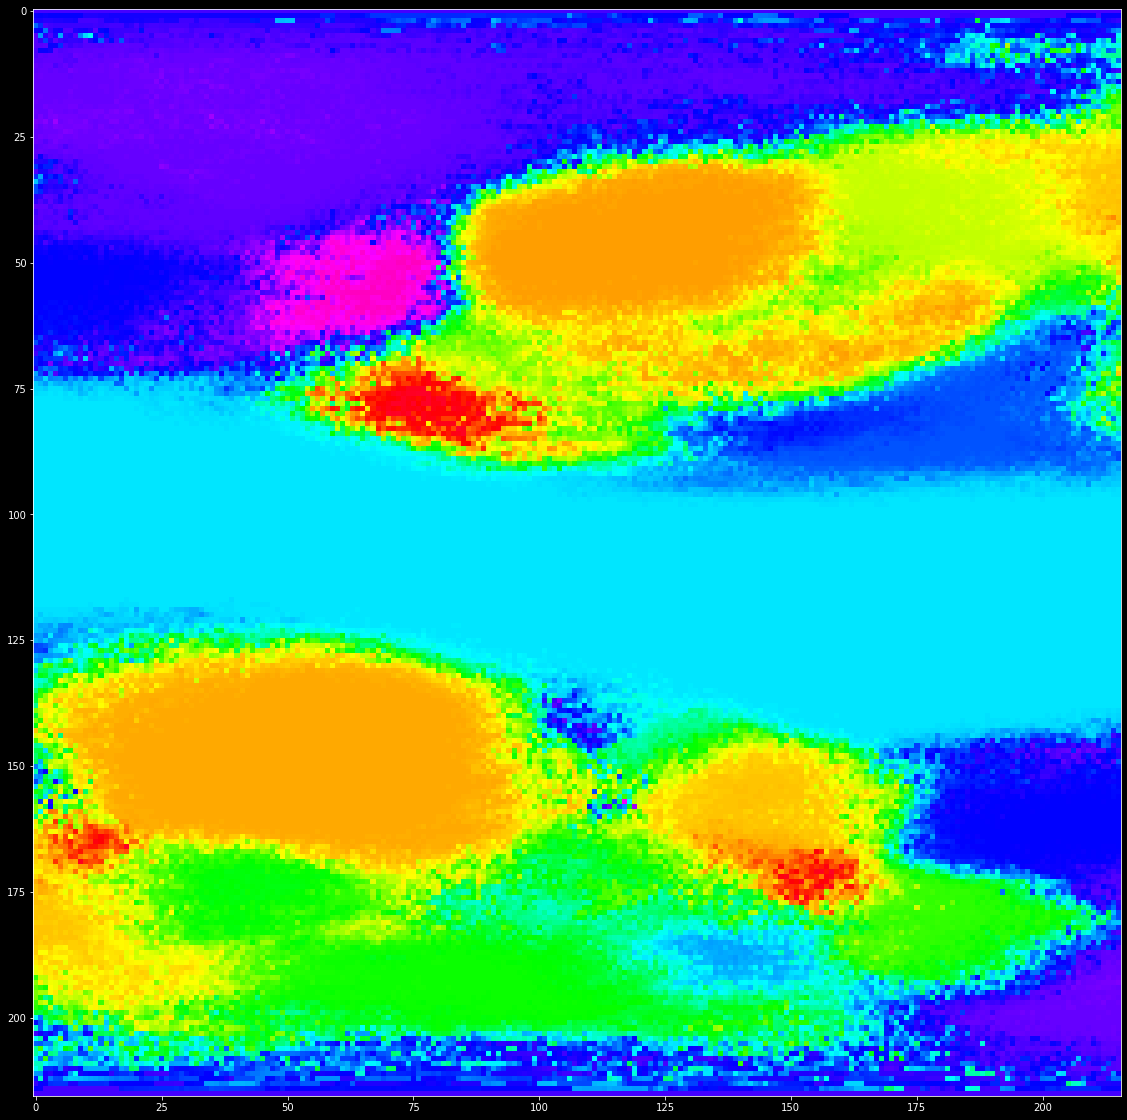

In [71]:
n = 2160
batch_size = n * 20
radius = 1.0

sizes = [(-jnp.pi/2, jnp.pi/2), (-jnp.pi, jnp.pi)]

grid = from_spherical(get_grid_ns(n=n, sizes=sizes), radius)
grid = grid.reshape(-1, grid.shape[-1])
out_grid = jnp.zeros((n * n,))
for i in tqdm(range(0, n * n, batch_size)):
    batch = pre_fn(grid[i:i+batch_size])
    out = find_fp_1var(batch)
    out_proj = vj_out_proj(out)
    #out_axis = out.argmax(axis=-1)/(out.shape[-1]-1)
    out_axis = (jax.nn.softmax(jnp.abs(out)) * jnp.linspace(0, 1, out.shape[-1], endpoint=False)).sum(axis=-1)
    out_grid = jax.ops.index_update(
        out_grid,
        jax.ops.index[i:i+out.shape[0]],
        out_axis
    )
    plt.scatter(
        out_proj[:,0],
        out_proj[:,1],
        s=1,
        c=plt.cm.gist_rainbow(out_axis)
    )
plt.style.use('dark_background')
plt.gcf().set_size_inches(40, 40)
plt.show()

plt.imshow(out_grid.reshape(n, n), cmap='gist_rainbow')
plt.gcf().set_size_inches(20, 20)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

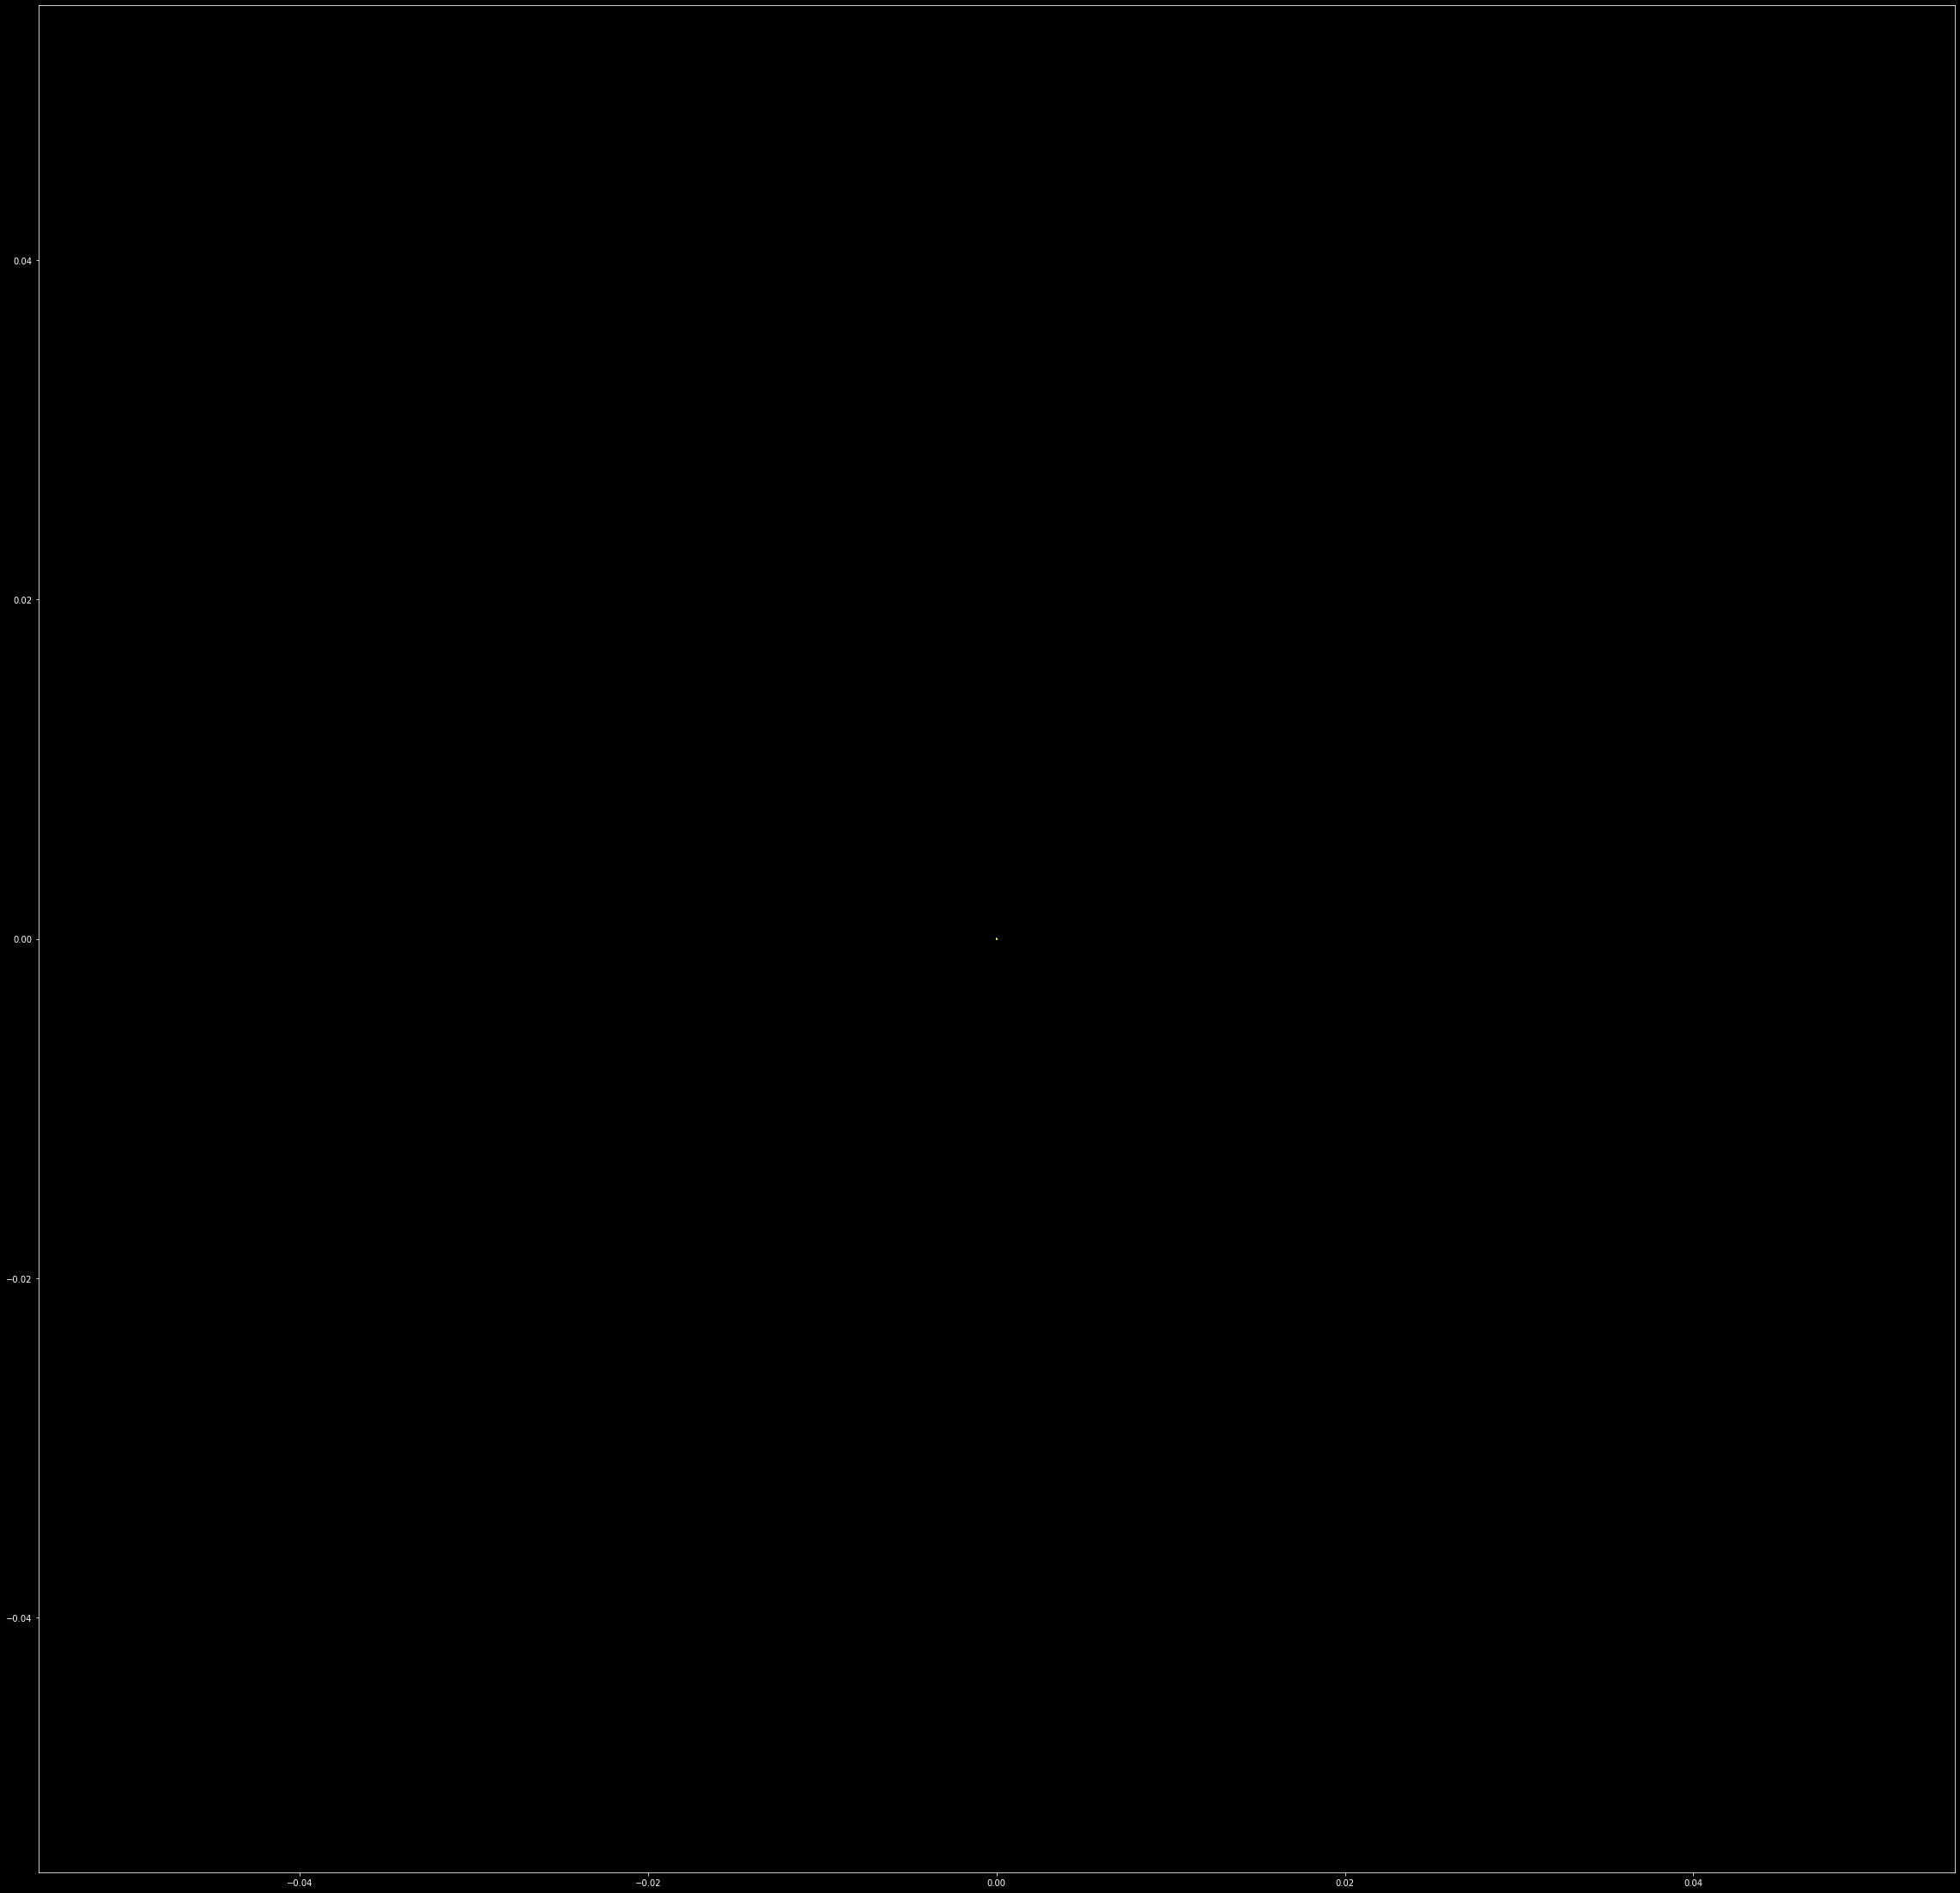

In [20]:
n = 50
batch_size = n * 1
radius = 1.0

sizes = [(-jnp.pi/2, jnp.pi/2), (-jnp.pi, jnp.pi)]

grid = from_spherical(get_grid_ns(n=n, sizes=sizes), radius)
grid = grid.reshape(-1, grid.shape[-1])
out_grid = jnp.zeros((n * n,))
for i in tqdm(range(0, n * n, batch_size)):
    batch = pre_fn(grid[i:i+batch_size])
    out = find_fp_1var(batch)
    sign, logdet, trace, jmin, jmax = vj_jac_det_tr(out)
    det = np.array(sign).astype(np.float64) * np.exp(np.array(logdet).astype(np.float64))
    #print(det.min(), det.max(), trace.min(), trace.max())
    #out_axis = out.argmax(axis=-1)/(out.shape[-1]-1)
    out_axis = (jax.nn.softmax(out) * jnp.linspace(0, 1, out.shape[-1], endpoint=False)).sum(axis=-1)
    #out_grid = jax.ops.index_update(
    #    out_grid,
    #    jax.ops.index[i:i+out.shape[0]],
    #    out_axis
    #)
    plt.scatter(
        det,
        trace,
        s=.1,
        c=plt.cm.gist_rainbow(out_axis)
    )
plt.style.use('dark_background')
plt.gcf().set_size_inches(40, 40)
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

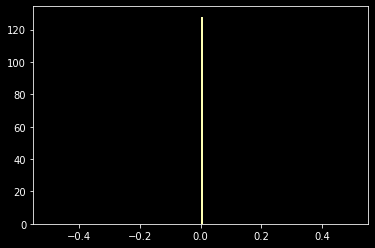

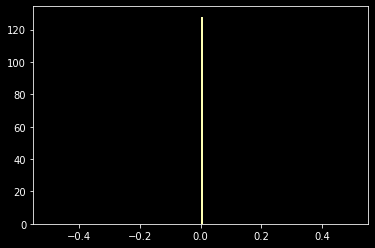

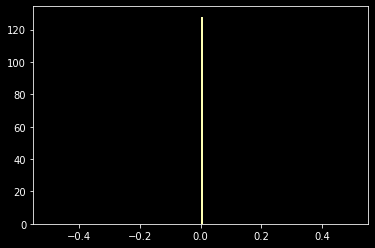

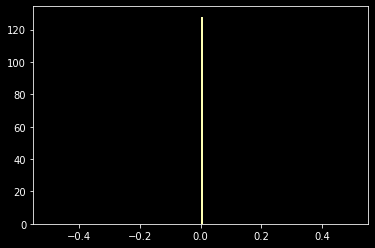

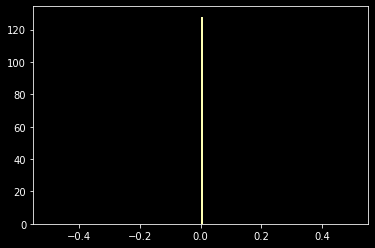

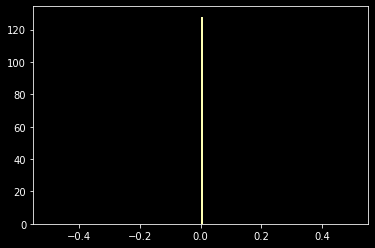

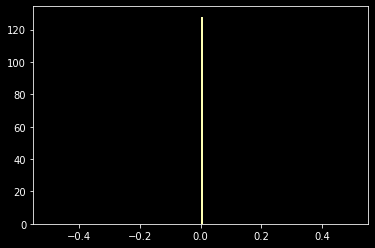

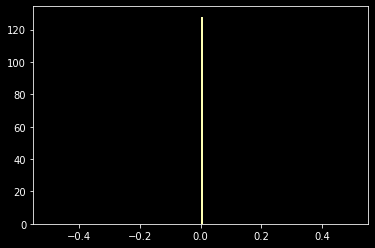

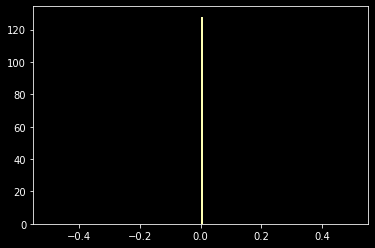

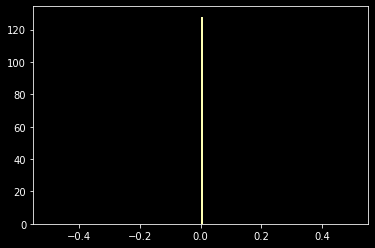

In [74]:
n = 10
batch_size = n * 1
radius = 1.0

sizes = [(-jnp.pi/2, jnp.pi/2), (-jnp.pi, jnp.pi)]

f = lambda x: jnp.linalg.norm(layer_noln.forward_apply(x), axis=-1)
eigvals_cpu = lambda x: jnp.linalg.eigvals(x)
eigvals_cpu = vmap(jit(eigvals_cpu, backend="cpu"))

grid = from_spherical(get_grid_ns(n=n, sizes=sizes), radius)
grid = grid.reshape(-1, grid.shape[-1])
out_grid = jnp.zeros((n * n,))
for i in tqdm(range(0, n * n, batch_size)):
    batch = pre_fn(grid[i:i+batch_size])
    out = find_fp_1var(batch, var_fn=lambda x: x.std(axis=-1))
    J = vmap(jit(layer_noln.jacobian))(out)
    H = vmap(jit(hessian(f)))(out)
    J_eigvals = eigvals_cpu(J)
    H_eigvals = eigvals_cpu(H)
    plt.hist(J_eigvals[0], bins=128)
    plt.hist(H_eigvals[0], bins=128)
    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

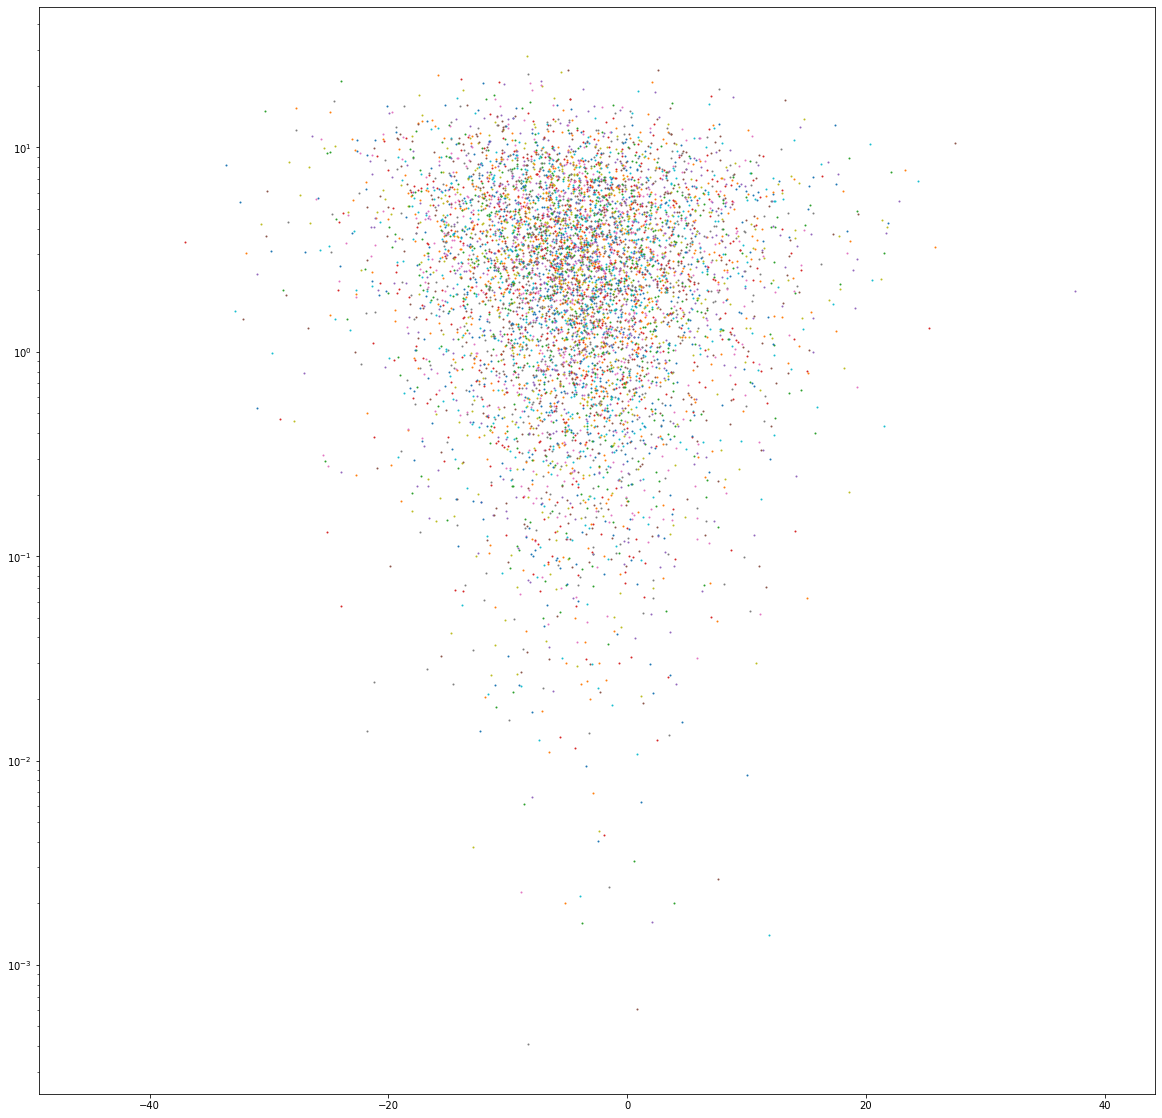

In [188]:
key = layer_noln.random_key
for i in tqdm(range(100)):
    key, subkey = jax.random.split(key)
    points = random_points(subkey)
    points_proj = vj_out_proj(find_fp_2norm(points))
    plt.scatter(
        points_proj[:,0], 
        points_proj[:,1],
        s=1
    )
plt.yscale('log')
plt.gcf().set_size_inches(20, 20)
plt.show()

In [150]:
jnp.linalg.norm(points[:,-1] - points[:,-2], axis=-1).max()

DeviceArray(0., dtype=float32)